## TD d1 Fitting

In [3]:
import pandas as pd
import glob
import os
import sys
! pip install pmcx
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
from pathlib import Path
import os, re

In [4]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)
from FD_msNIRS_2layers import extract_freq as ef

Mounted at /content/drive


### GT

In [6]:
train_sorted_ids = [i+1 for i in range(10000)]
GT_folder_train = '/content/drive/MyDrive/MCX_data/stage2_csv/'
csv_files = glob.glob(os.path.join(GT_folder_train, '*.csv'))
GT_all_train = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

# Ensure ID column is integer
GT_all_train['ID'] = GT_all_train['ID'].astype(int)

# Filter and sort GT_all to match the sorted_ids order
GT_filtered = GT_all_train[GT_all_train['ID'].isin(train_sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[train_sorted_ids].reset_index()

# Extract HHB2 as Y
Y_train = GT_filtered['d1'].values  # numpy array (n_samples,)
Y_train = Y_train.reshape(-1, 1)
print(Y_train.shape)

(10000, 1)


In [7]:
test_sorted_ids = [i+1 for i in range(1000)]
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'
csv_files = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

GT_all_test['ID'] = GT_all_test['ID'].astype(int)

GT_filtered = GT_all_test[GT_all_test['ID'].isin(test_sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[test_sorted_ids].reset_index()

Y_test = GT_filtered['d1'].values  # numpy array (n_samples,)
Y_test = Y_test.reshape(-1, 1)
print(Y_test.shape)

(1000, 1)


#### scale X and Y

In [8]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler_y  = StandardScaler()
Y_train = scaler_y.fit_transform(Y_train.reshape(-1, 1)).ravel()
Y_test  = scaler_y.transform(Y_test.reshape(-1, 1)).ravel()

In [9]:
pth = '/content/drive/MyDrive/MCX_data/weights_td/'
joblib.dump(scaler_y, pth+"TD_thickness_CNN_scaler_y.pkl")
SAVE_DIR = Path("/content/drive/MyDrive/MCX_data/splits")
data    = np.load(SAVE_DIR / "train_test_split.npz", allow_pickle=False)
X_train = data["X_train"]
X_test  = data["X_test"]

In [10]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(10000, 64, 1000) (1000, 64, 1000) (10000,) (1000,)


### ANN

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add,
    MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
)
from pathlib import Path
import joblib, tensorflow as tf


def residual_block(x, filters, kernel_size=(5, 5), downsample=False, dropout_rate=0.0):
    shortcut = x

    # First conv
    x = Conv2D(filters, kernel_size, padding='same', strides=(2, 2) if downsample else (1, 1))(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # Second conv
    x = Conv2D(filters, kernel_size, padding='same')(x)

    # Shortcut path
    if downsample or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=(2, 2) if downsample else (1, 1), padding='same')(shortcut)

    # Merge
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Input
input_tensor = Input(shape=(64, 1000, 1))

# Initial Conv Layer
x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_tensor)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Residual Blocks
x = residual_block(x, 128, downsample=True, dropout_rate=0.0)
x = residual_block(x, 128)

x = residual_block(x, 128, downsample=True, dropout_rate=0.0)
x = residual_block(x, 128)

x = residual_block(x, 256, downsample=True, dropout_rate=0.0)
x = residual_block(x, 256)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Dense Head
x = Dense(128, activation='relu')(x)
x = Dropout(0.0)(x)
x = Dense(64, activation='relu')(x)
x = Dense(1)(x)

# Build model
resnet_model = Model(inputs=input_tensor, outputs=x)

# 1) Create a checkpoint callback that saves the best model:
checkpoint_cb = ModelCheckpoint(
    "TD_d1_CNN.keras",        # filepath to save to
    monitor="val_loss",     # quantity to monitor
    mode="min",             # we want to minimize val_loss
    save_best_only=True,    # only save when val_loss decreases
    save_weights_only=False # set True if you only want weights
)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
resnet_model.compile(optimizer=optimizer, loss="mse")

# 3) Fit with the checkpoint callback
history = resnet_model.fit(
    X_train, Y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint_cb]
)

# 4) Later on (or in a new script), load the best model:
model = tf.keras.models.load_model("TD_d1_CNN.keras")

Epoch 1/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 38s 74ms/step - loss: 0.8094 - val_loss: 0.6975
Epoch 2/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.6660 - val_loss: 0.6288
Epoch 3/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.6277 - val_loss: 0.5371
Epoch 4/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.5377 - val_loss: 0.4641
Epoch 5/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.4218 - val_loss: 0.2472
Epoch 6/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.2297 - val_loss: 0.1376
Epoch 7/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.1440 - val_loss: 0.0978
Epoch 8/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.1064 - val_loss: 0.0871
Epoch 9/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0804 - val_loss: 0.0653
Epoch 10/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0738 - val_loss: 0.0627
Epoch 11/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0511 - val_loss: 0.0761
Epoch 12/200
282/282

In [12]:
WEIGHT_DIR = Path("/content/drive/MyDrive/MCX_data/weights_td/")
WEIGHT_DIR.mkdir(parents=True, exist_ok=True)
model_path = WEIGHT_DIR / "TD_d1_CNN.keras"
model.save(model_path)

print("model file exists:", model_path.exists(),
      "size =", model_path.stat().st_size/1e6, "MB")

model file exists: True size = 105.794187 MB


In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 1000,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 1000,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 500,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 250,   │    102,528 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 250,   │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 250,   │          0 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 250,   │    409,728 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 250,   │      4,224 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 250,   │          0 │ conv2d_2[0][0],   │
│                     │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 250,   │          0 │ add[0][0]         │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 250,   │    409,728 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 250,   │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 250,   │          0 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 250,   │    409,728 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 250,   │          0 │ conv2d_5[0][0],   │
│                     │ 128)              │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 250,   │          0 │ add_1[0][0]       │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 125,    │    409,728 │ activation_3[0][

 Total params: 26,404,037 (100.72 MB)

 Trainable params: 8,801,345 (33.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,602,692 (67.15 MB)

In [52]:
# Predict and evaluate
y_pred = resnet_model.predict(X_test)
y_pred = np.clip(y_pred, scaler_y.transform(np.array([[10]]))[0][0], scaler_y.transform(np.array([[20]]))[0][0])
mse = mean_squared_error(Y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test MSE: 0.0109


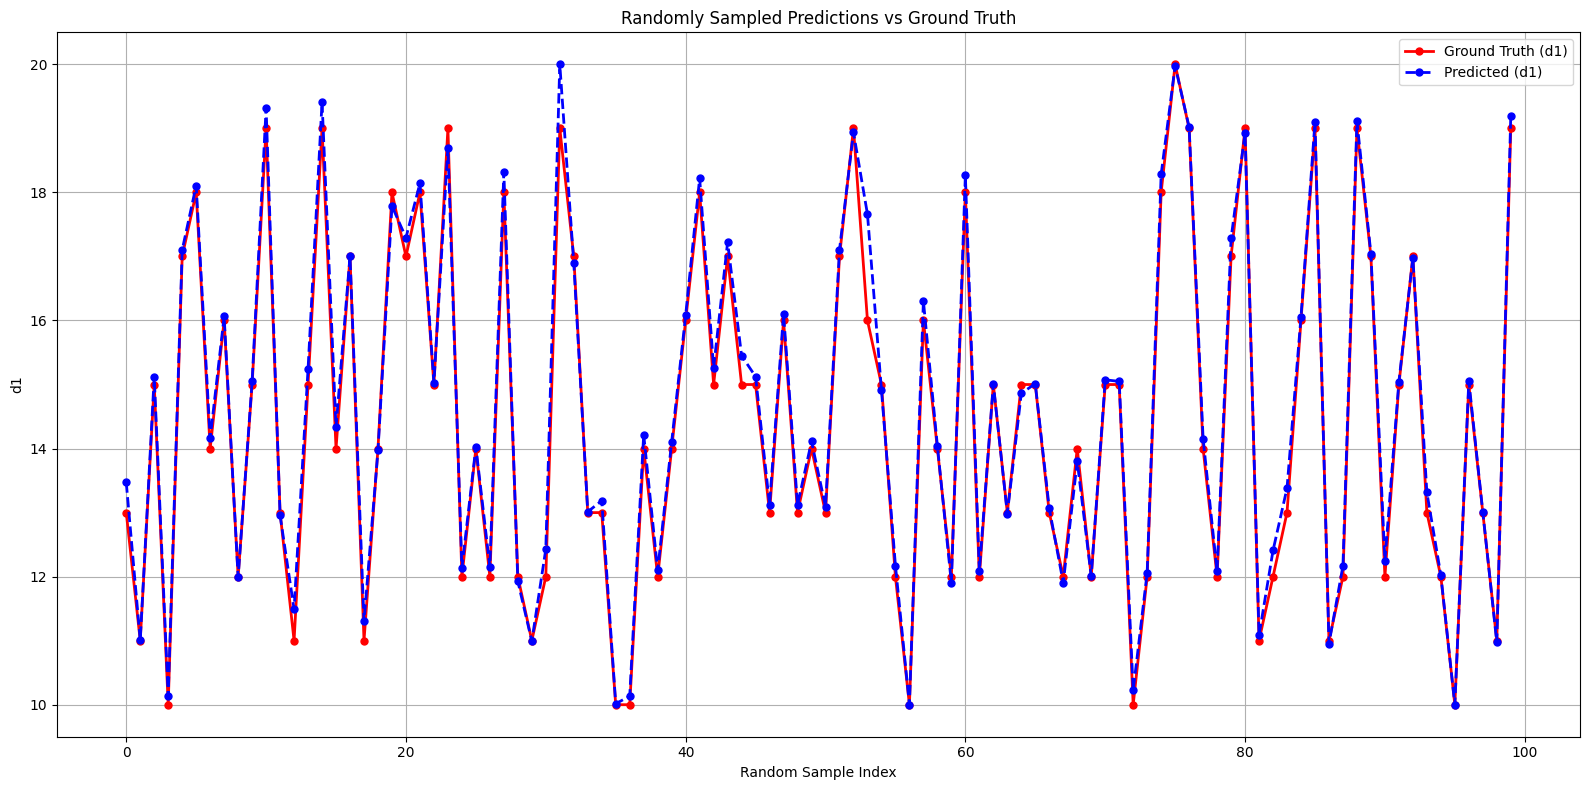

In [53]:
# Randomly select 100 indices
import numpy as np
import matplotlib.pyplot as plt

indices = np.random.choice(len(Y_test), size=100, replace=False)
indices = np.sort(indices)

y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()

# Extract corresponding values
y_test_sampled = y_test_rescaled[indices]
y_pred_sampled = y_pred_rescaled[indices]

# Plot with circular markers
plt.figure(figsize=(16, 8))
plt.plot(y_test_sampled, 'r-o', label='Ground Truth (d1)', linewidth=2, markersize=5)
plt.plot(y_pred_sampled, 'b--o', label='Predicted (d1)', linewidth=2, markersize=5)
plt.xlabel('Random Sample Index')
plt.ylabel('d1')
plt.title('Randomly Sampled Predictions vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Test MSE (original scale): 0.0924


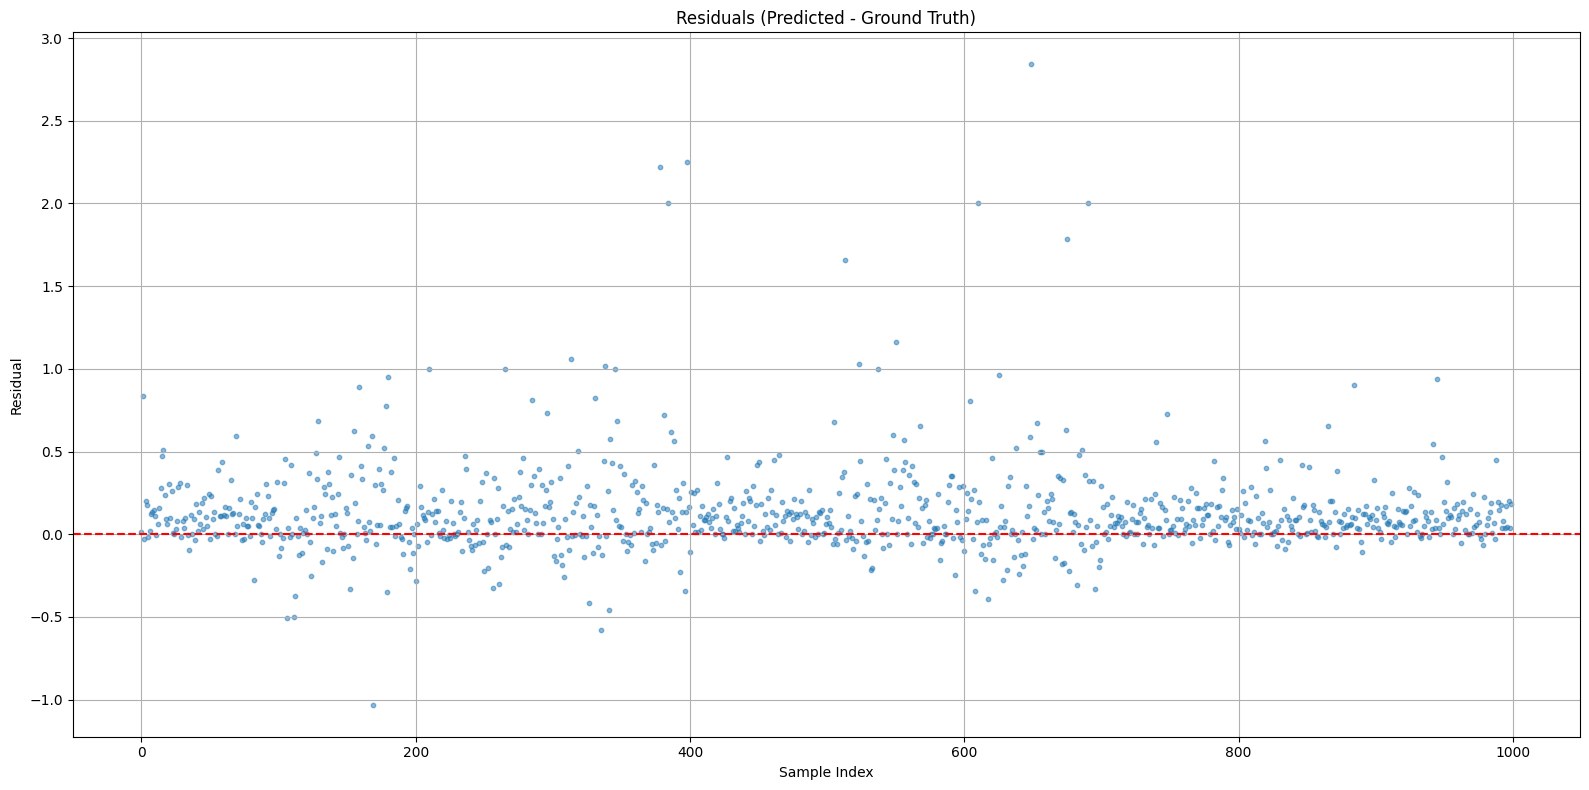

In [54]:

# Compute residuals in original scale
residuals = y_pred_rescaled - y_test_rescaled

mse_rescaled = mean_squared_error(y_pred_rescaled, y_test_rescaled)
print(f"Test MSE (original scale): {mse_rescaled:.4f}")

# Plot residuals
plt.figure(figsize=(16, 8))
plt.scatter(range(len(residuals)), residuals, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals (Predicted - Ground Truth)")
plt.ylabel("Residual")
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()

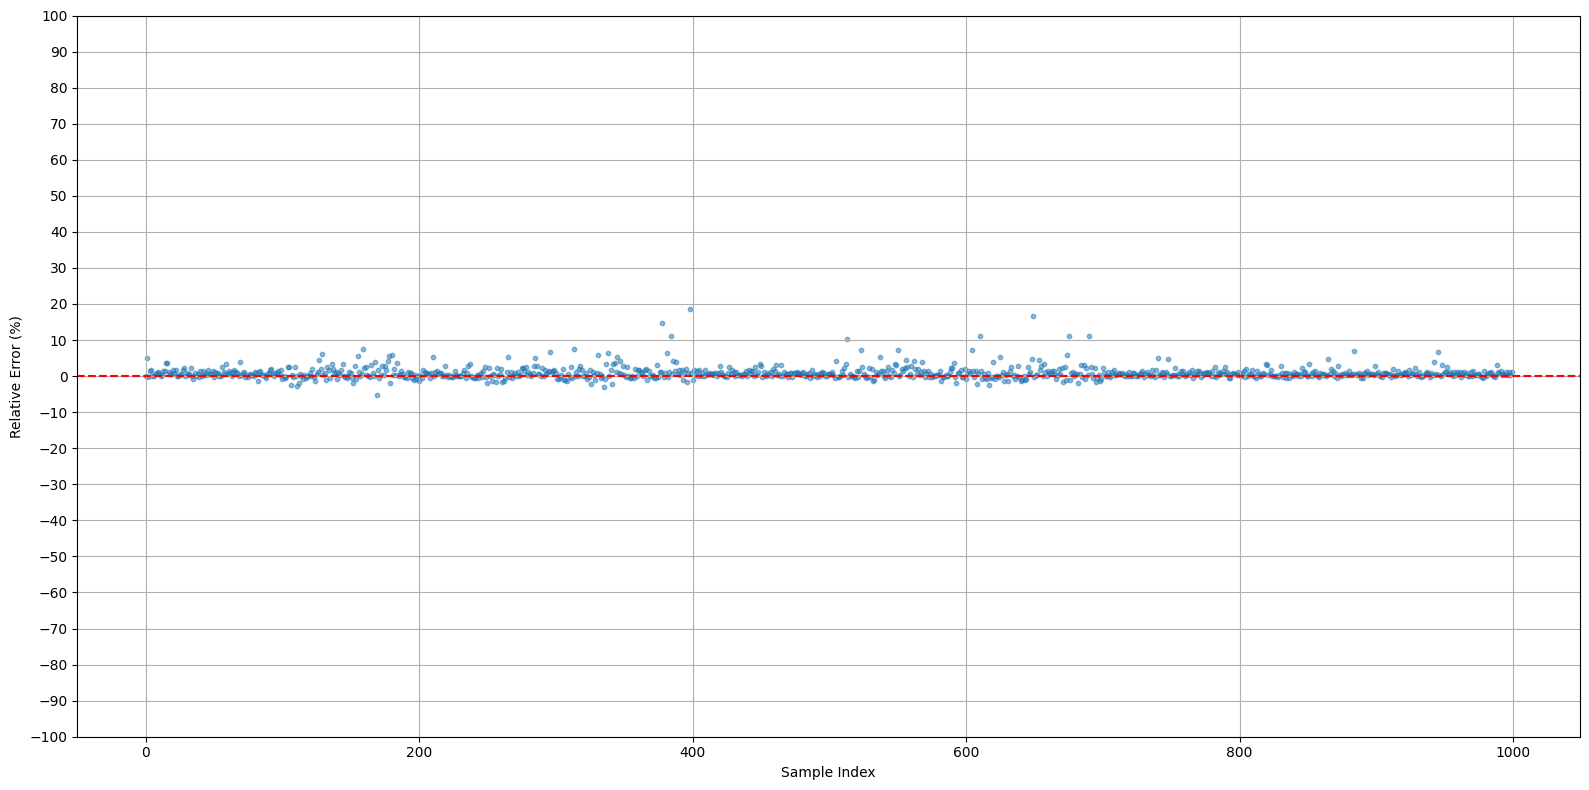

In [55]:
# Compute relative error (percentage)
relative_error = ((y_pred_rescaled - y_test_rescaled) / y_test_rescaled) * 100

# Plot relative error
plt.figure(figsize=(16, 8))
plt.scatter(range(len(relative_error)), relative_error, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.ylabel("Relative Error (%)")
plt.yticks(np.arange(-100, 101, 10))
plt.ylim(-100, 100)
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()

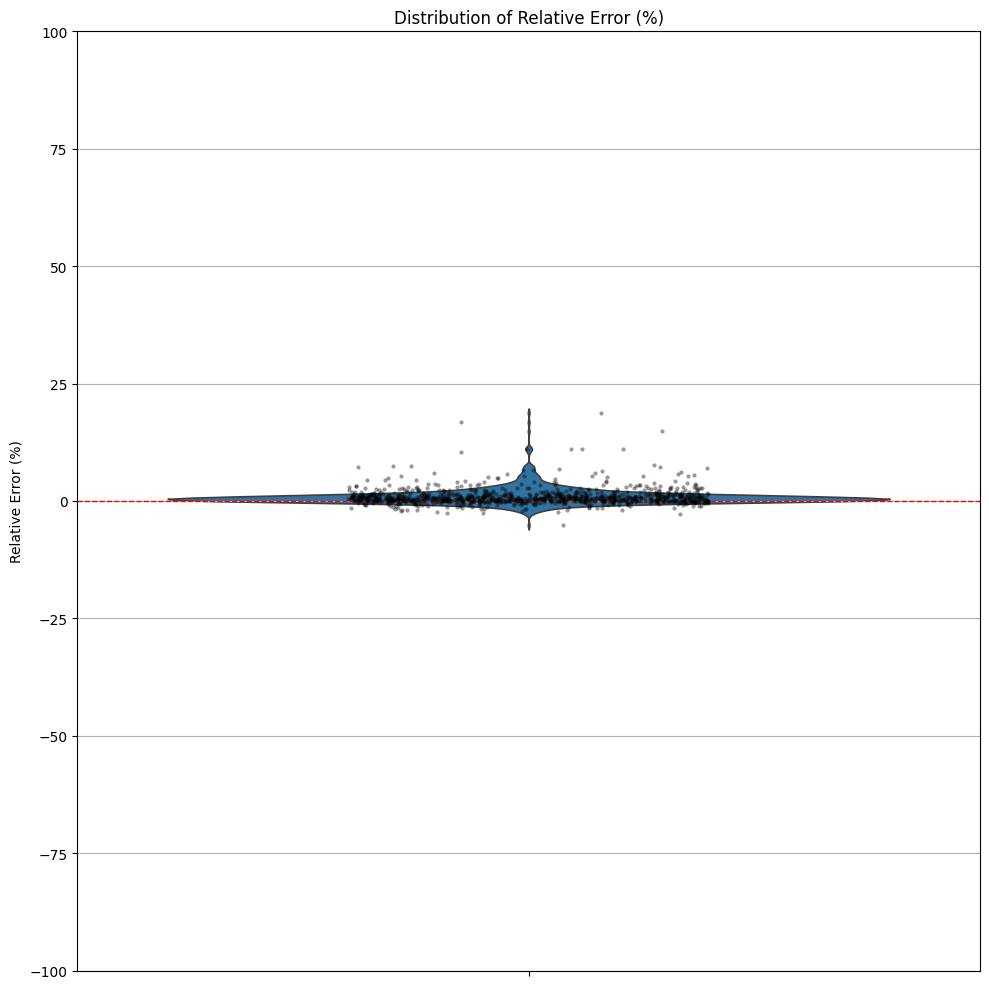

In [56]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare DataFrame for seaborn
df_plot = pd.DataFrame({
    'Relative Error (%)': relative_error.flatten()
})

plt.figure(figsize=(10, 10))
sns.violinplot(data=df_plot, y='Relative Error (%)', inner=None, linewidth=1.2)
sns.stripplot(data=df_plot, y='Relative Error (%)', color='black', alpha=0.4, jitter=0.2, size=3)

plt.axhline(0, color='r', linestyle='--', linewidth=1)
plt.ylim(-100, 100)
plt.title('Distribution of Relative Error (%)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


R² = 0.9891145854087615
MAPE = 1.1657566090175009 %


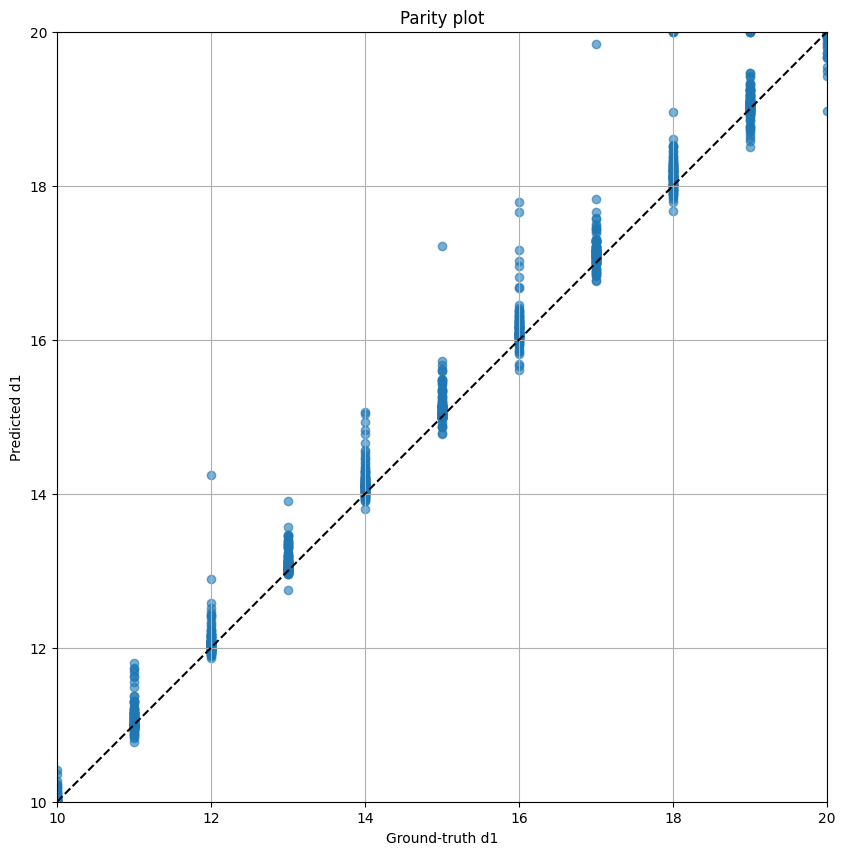

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_percentage_error

plt.figure(figsize=(10,10))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.6)
lims = [min(y_test_rescaled.min(), y_pred_rescaled.min()),
        max(y_test_rescaled.max(), y_pred_rescaled.max())]
plt.plot(lims, lims, 'k--')              # identity line
plt.xlabel('Ground-truth d1'); plt.ylabel('Predicted d1')
plt.title('Parity plot')
plt.axis('square'); plt.xlim(lims); plt.ylim(lims)
plt.grid()
print("R² =", r2_score(y_test_rescaled, y_pred_rescaled))
print("MAPE =", mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)*100, "%")
plt.show()

kept 982 of 1000 points
R²   = 0.9945087811921194
MAPE = 1.0188214654406809 %


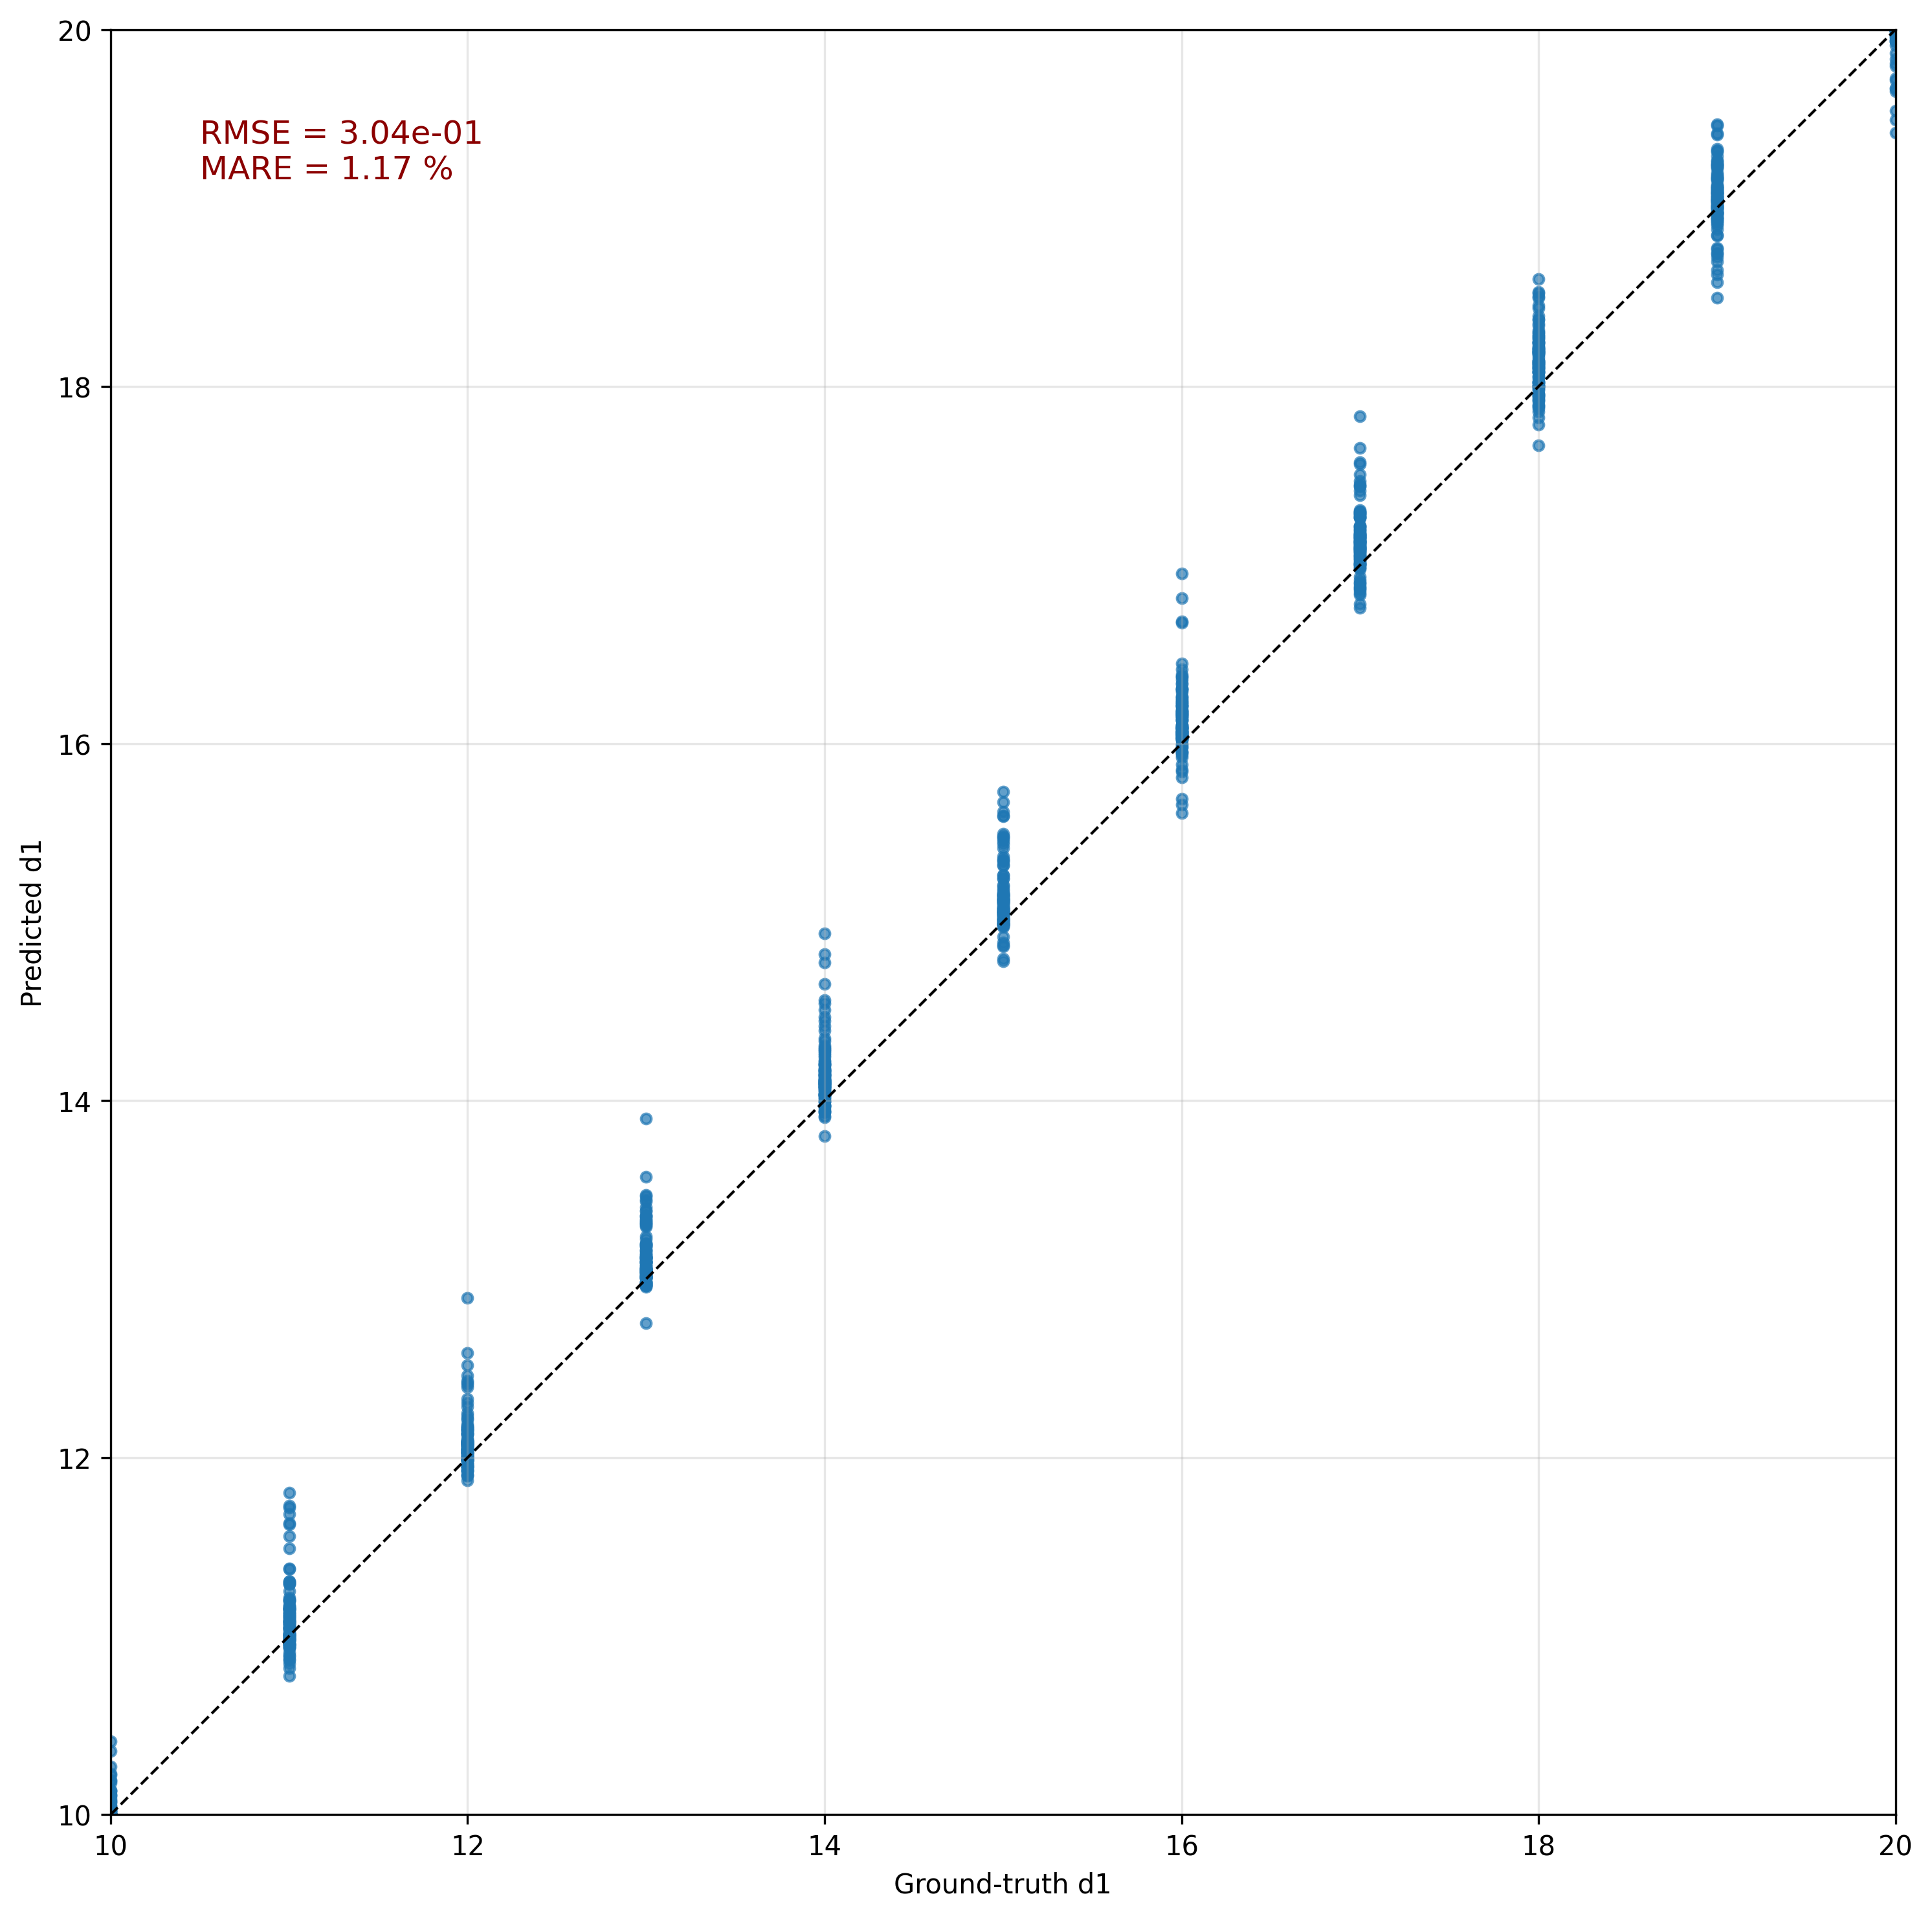

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

# ------------------------------------------------------------------
# original arrays
x = y_test_rescaled.ravel()     # ground-truth
y = y_pred_rescaled.ravel()     # prediction
# ------------------------------------------------------------------

# 1️⃣  3-sigma filter on residuals
mask = np.abs(zscore(y - x)) < 3
x_in, y_in = x[mask], y[mask]

# 2️⃣  parity plot
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)   # ← 10×10 inches

rmse = np.sqrt(mean_squared_error(x, y))
mare = mean_absolute_percentage_error(x, y) * 100
ax.text(0.05, 0.95,
        f'RMSE = {rmse:.2e}\nMARE = {mare:.2f} %',
        transform=ax.transAxes, ha='left', va='top',
        fontsize=12, color='darkred')

ax.scatter(x_in, y_in, s=14, alpha=0.7)
lims = [min(x_in.min(), y_in.min()), max(x_in.max(), y_in.max())]
ax.plot(lims, lims, 'k--', lw=1)
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('Ground-truth d1')
ax.set_ylabel('Predicted d1')
ax.grid(alpha=0.3)

# 3️⃣  metrics on filtered set
print("kept", mask.sum(), "of", len(x), "points")
print("R²   =", r2_score(x_in, y_in))
print("MAPE =", mean_absolute_percentage_error(x_in, y_in)*100, "%")

fig.tight_layout()
plt.show()


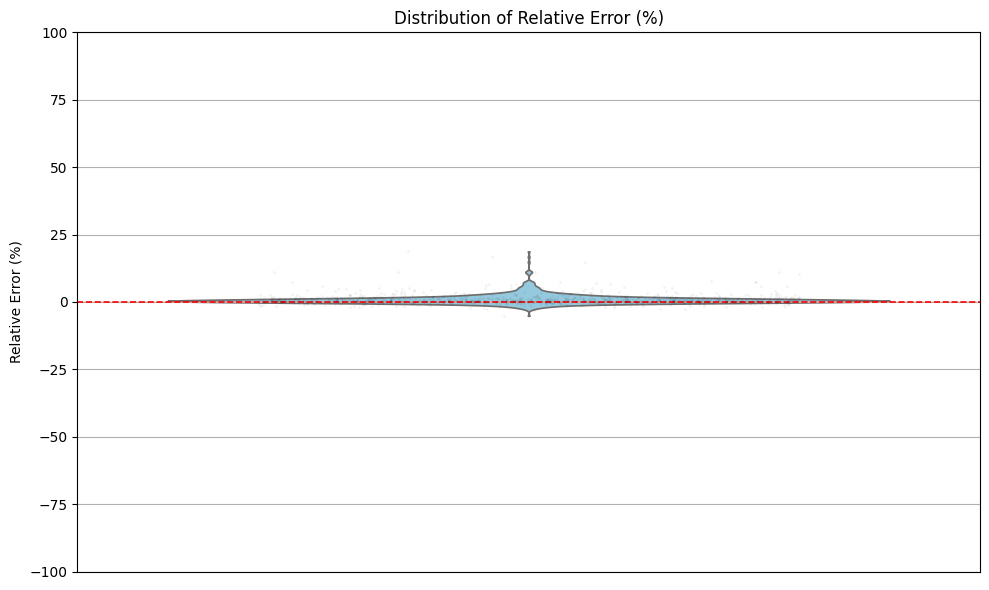

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))
sns.violinplot(y=relative_error, inner=None, color='skyblue', cut=0)
sns.stripplot(y=relative_error, color='black', alpha=0.05, jitter=0.3, size=2)

plt.axhline(0, color='red', linestyle='--', linewidth=1.2)
plt.title('Distribution of Relative Error (%)')
plt.ylabel('Relative Error (%)')
plt.grid()
plt.xticks([])
plt.ylim(-100, 100)
plt.tight_layout()
plt.show()

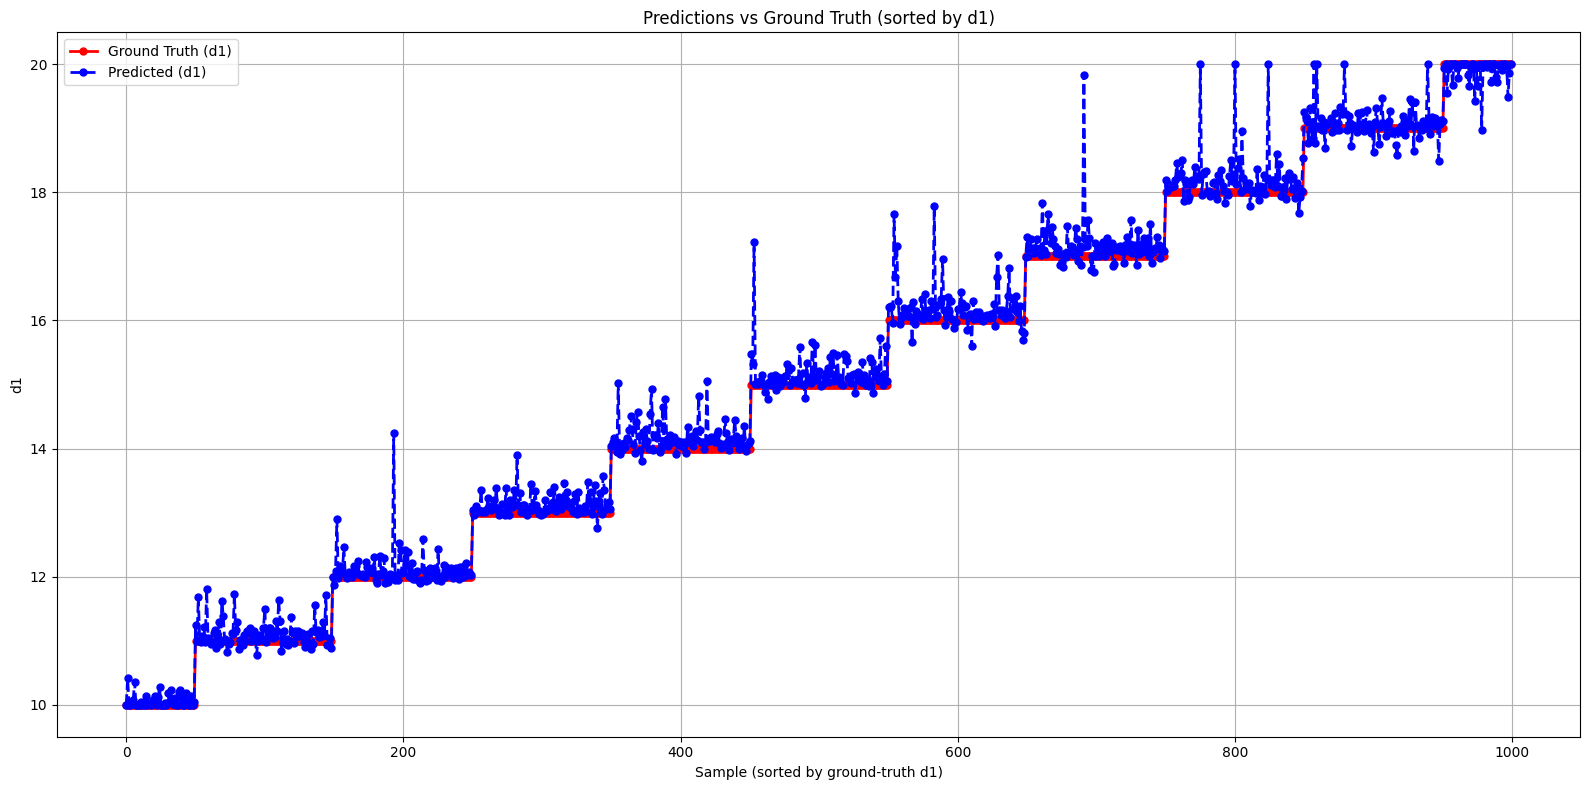

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ── Sort by ground-truth values (ascending) ───────────────────────────────
sorted_idx       = np.argsort(y_test_rescaled)         # indices that sort y_test
y_test_sorted    = y_test_rescaled[sorted_idx]
y_pred_sorted    = y_pred_rescaled[sorted_idx]

# ── Plot both curves with matching order ──────────────────────────────────
plt.figure(figsize=(16, 8))
plt.plot(y_test_sorted, 'r-o',  label='Ground Truth (d1)', linewidth=2, markersize=5)
plt.plot(y_pred_sorted, 'b--o', label='Predicted (d1)',   linewidth=2, markersize=5)
plt.xlabel('Sample (sorted by ground-truth d1)')
plt.ylabel('d1')
plt.title('Predictions vs Ground Truth (sorted by d1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


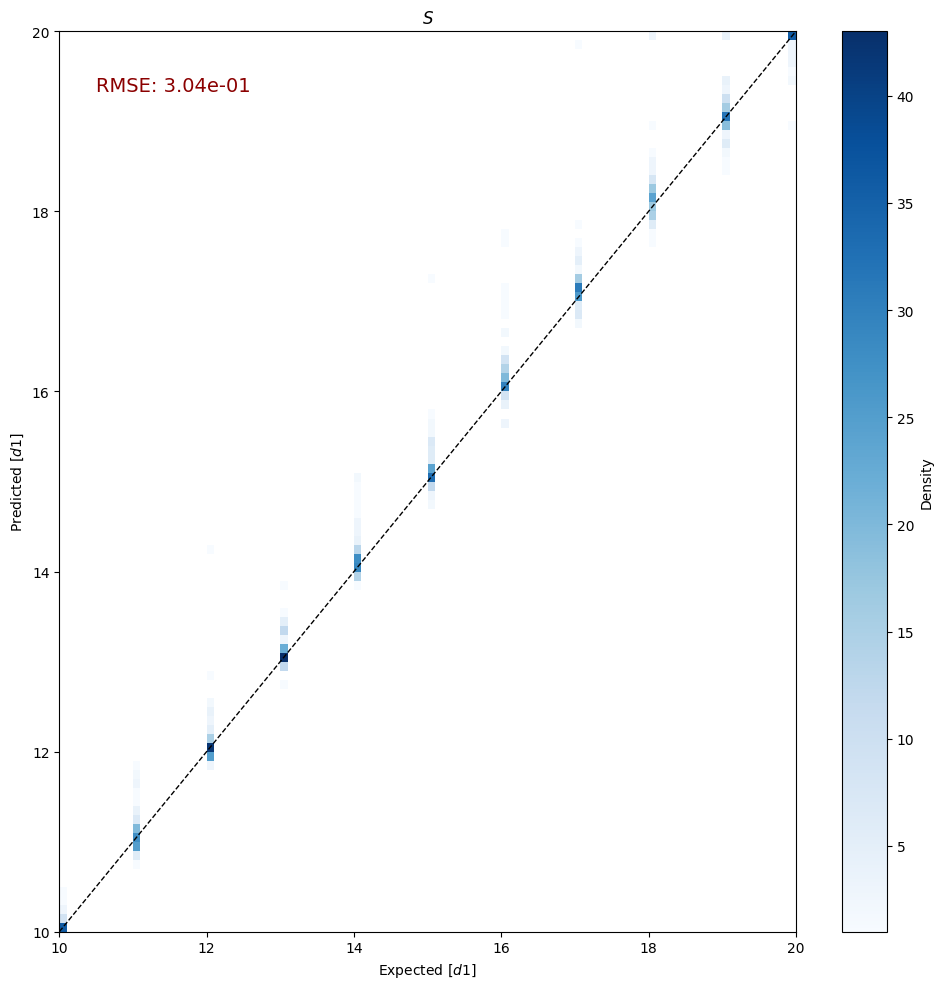

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Ensure y_true and y_pred are 1D numpy arrays
y_true = np.asarray(y_test_rescaled).ravel()
y_pred =np.asarray(y_pred_rescaled).ravel()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Plot
plt.figure(figsize=(10, 10))
plt.hist2d(y_true, y_pred, bins=100, cmap='Blues', cmin=1)

# Plot identity line
plt.plot([min(y_true), max(y_true)],
         [min(y_true), max(y_true)],
         'k--', lw=1)

# Labels and title
plt.xlabel('Expected $[d1]$')
plt.ylabel('Predicted $[d1]$')
plt.title(r'$S$')

# Annotate RMSE
plt.text(0.05, 0.95, f'RMSE: {rmse:.2e}', color='darkred',
         fontsize=14, transform=plt.gca().transAxes, va='top')

plt.colorbar(label='Density')
plt.tight_layout()
plt.show()

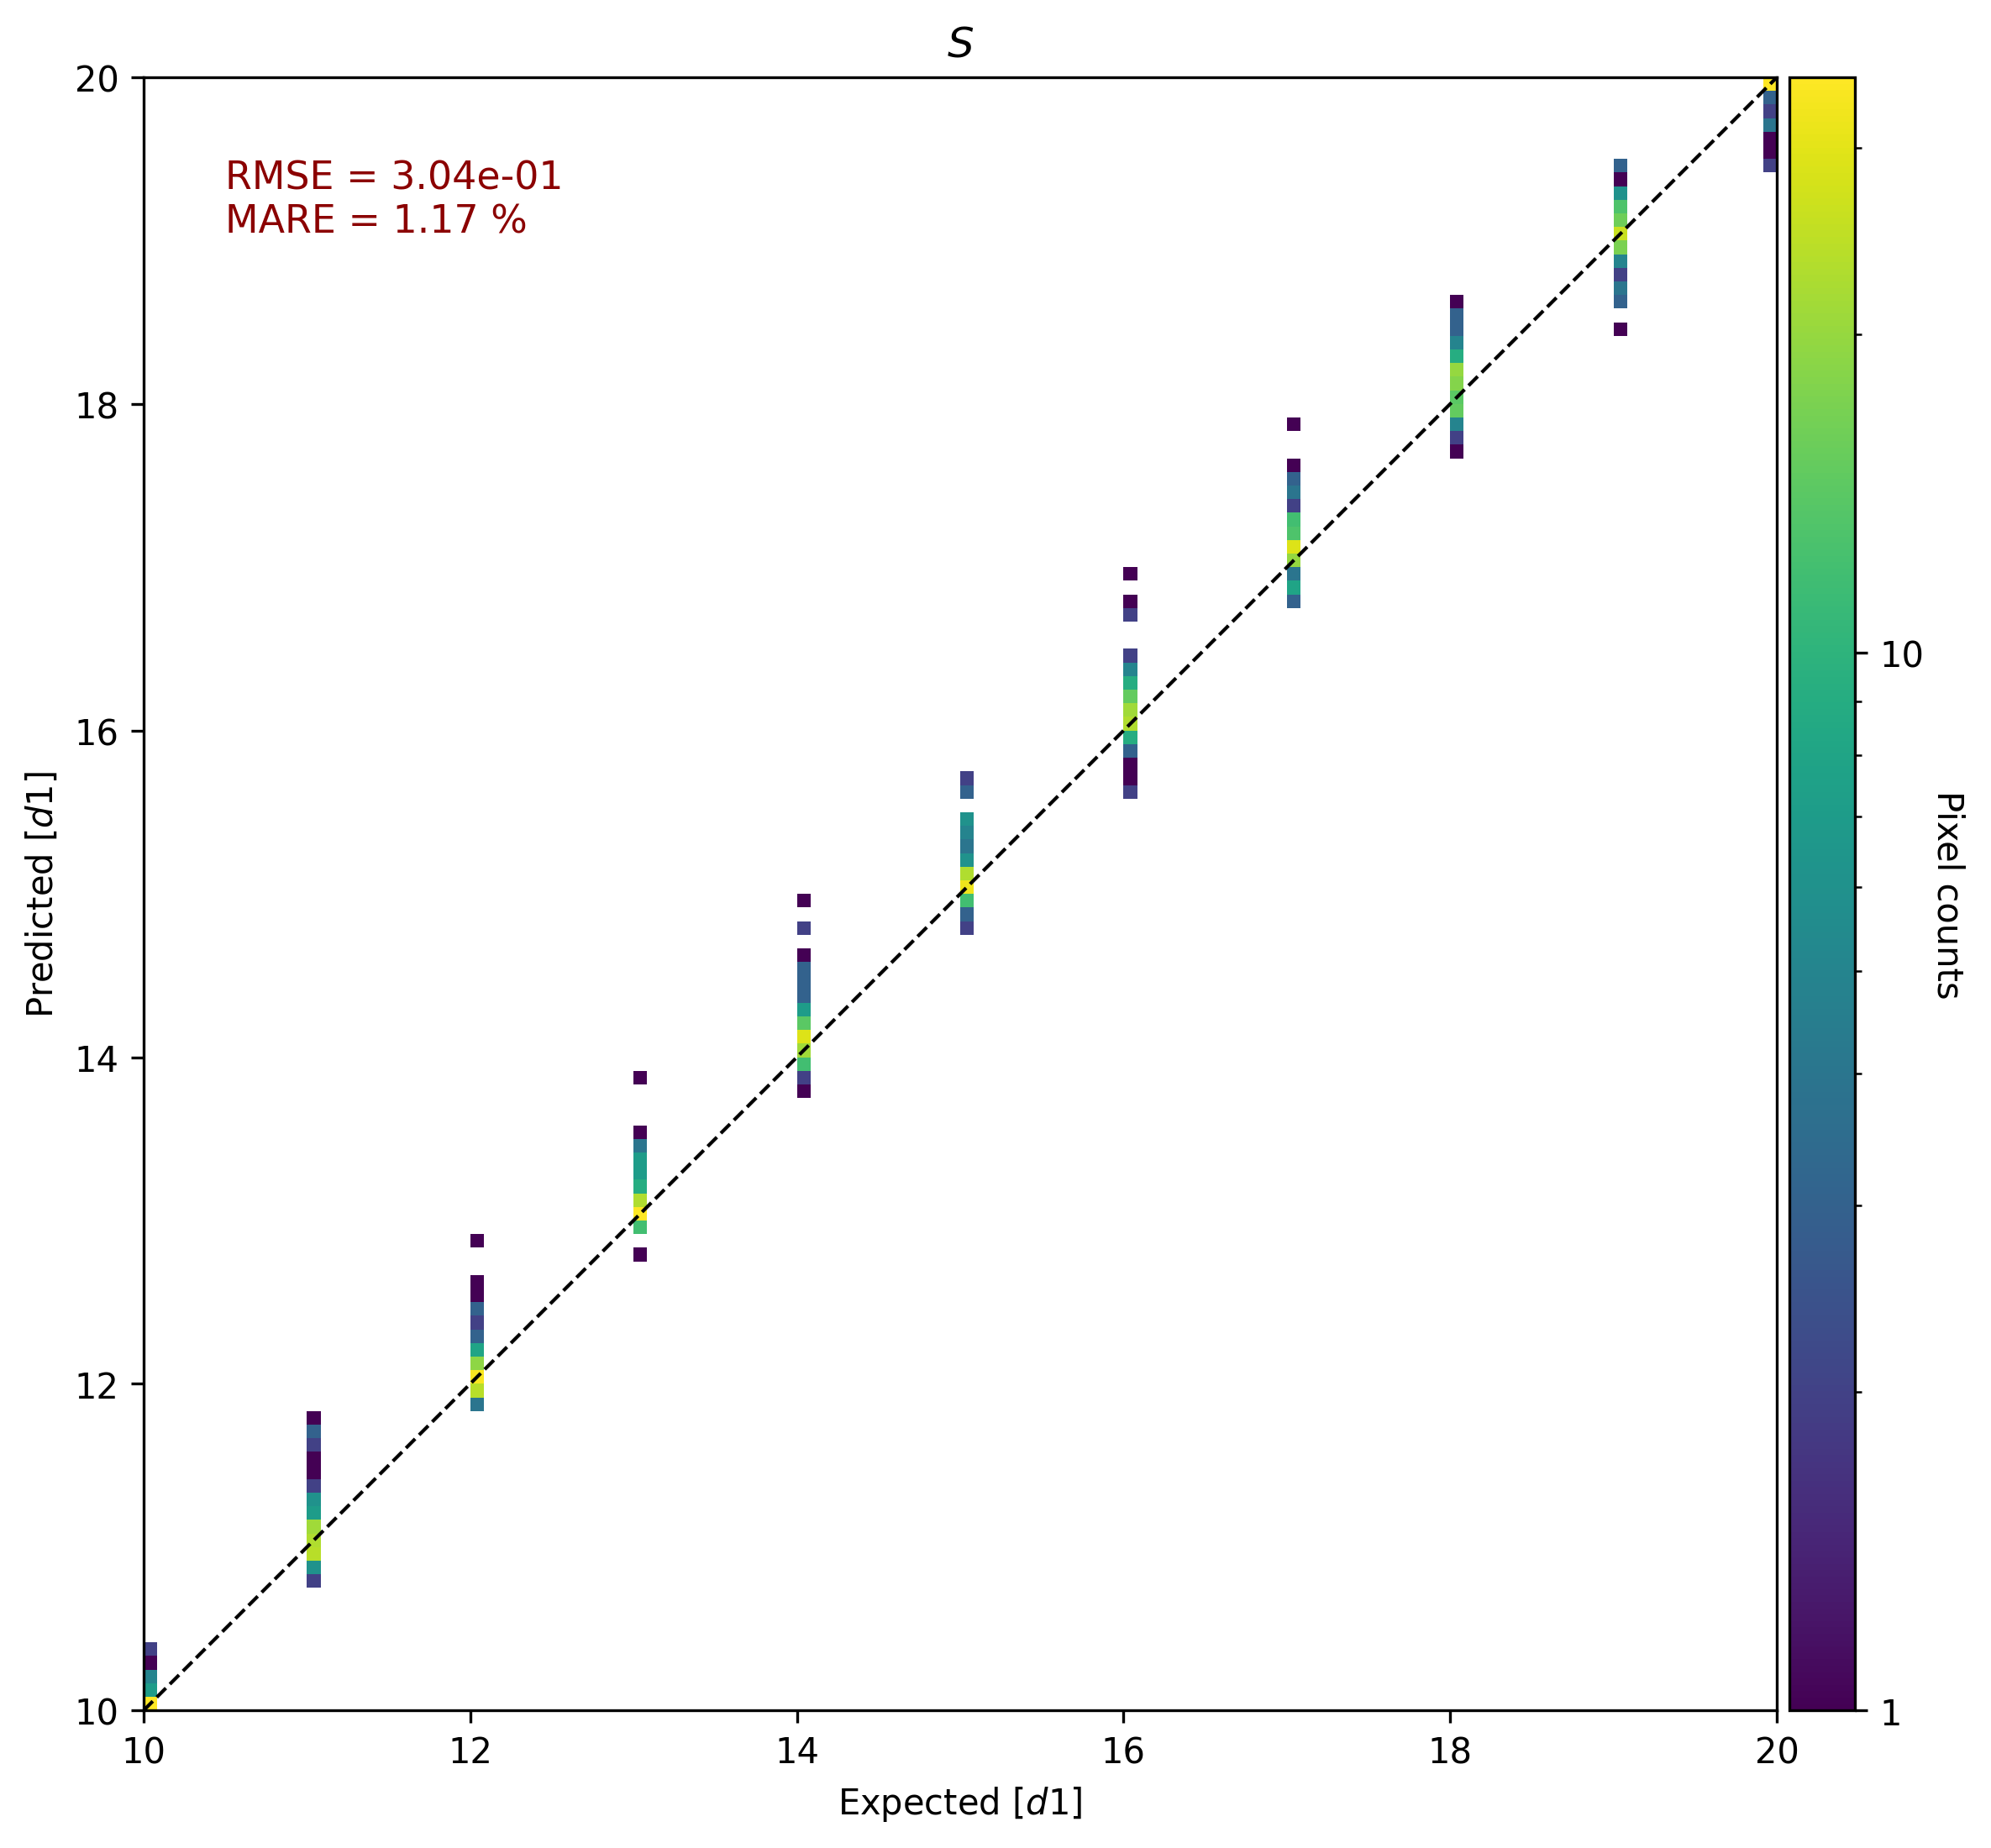

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.stats import zscore

# ── 0 │  flatten + 3-σ outlier filter  ─────────────────────────────────────────
y_true = np.asarray(y_test_rescaled).ravel()   # ground truth
y_pred = np.asarray(y_pred_rescaled).ravel()   # model prediction

mask   = np.abs(zscore(y_pred - y_true)) < 3   # keep inliers only
x, y   = y_true[mask], y_pred[mask]            # filtered data for the plot

# ── 1 │  metrics (use full set or filtered—here full)  ─────────────────────────
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mare = mean_absolute_percentage_error(y_true, y_pred) * 100    # %

# ── 2 │  parity plot with 2-D log-density  ─────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

h = ax.hist2d(
        x, y,
        bins=120,
        cmap="viridis",
        norm=LogNorm(vmin=1)                    # log colour scale
    )

# identity line
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
ax.plot(lims, lims, 'k--', lw=1)
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_aspect('equal', adjustable='box')

# labels / title
ax.set_xlabel(r'Expected $[d1]$')
ax.set_ylabel(r'Predicted $[d1]$')
ax.set_title(r'$S$')

# metrics annotation
ax.text(0.05, 0.95,
        f'RMSE = {rmse:.2e}\nMARE = {mare:.2f} %',
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=11, color='darkred')

# ── 3 │  colour bar same height as square, plain-number ticks  ────────────────
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
cb  = fig.colorbar(h[3], cax=cax)

# plain numbers (1, 2, 5, 10 ...), no “×10⁰”
cb.ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f'{v:g}'))
cb.set_label('Pixel counts', rotation=270, labelpad=12)

fig.tight_layout()
plt.show()


In [63]:
# Small epsilon to avoid division by zero
eps = 1e-8

# Relative error (%)
relative_error = (y_pred - y_true) / (y_true + eps) * 100
absolute_relative_error = np.abs(relative_error)

# Compute metrics
mre = np.mean(relative_error)
mape = np.mean(absolute_relative_error)

# Print
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

Mean Absolute Percentage Error (MAPE): 1.1658%


In [64]:
lower, upper = np.percentile(relative_error, [16, 84])
print(f"68% CI of d1 % error: {lower:.2f}% to {upper:.2f}%")

68% CI of d1 % error: -0.15% to 1.81%


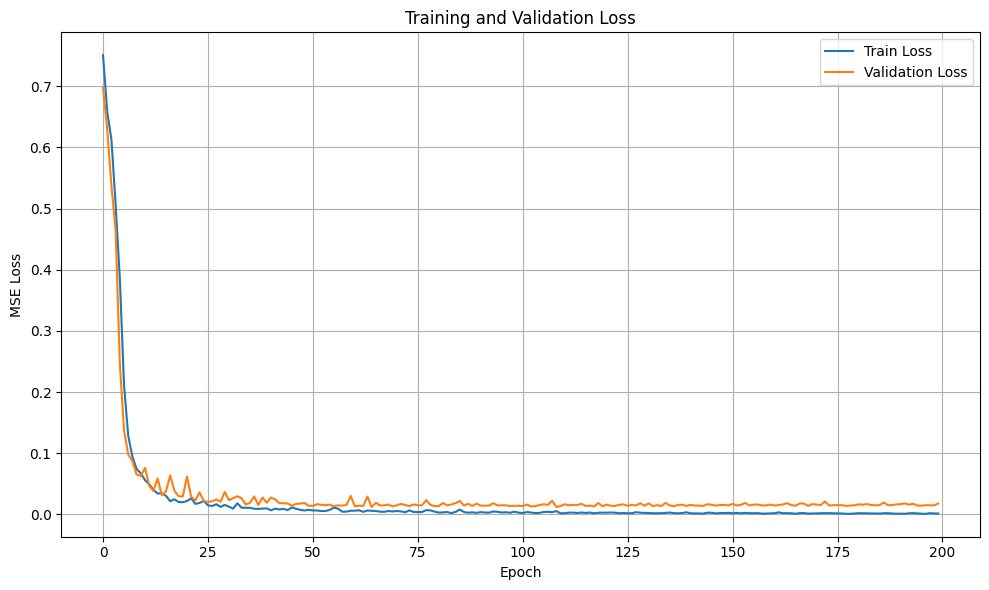

In [65]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()